In [1]:
from __future__ import absolute_import, division, print_function

import json
import multiprocessing
import os

import click
import joblib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import yaml
from addict import Dict
from PIL import Image
from tensorboardX import SummaryWriter
from torchnet.meter import MovingAverageValueMeter
from tqdm import tqdm

from libs.datasets import get_dataset
from libs.models import *
from libs.utils import DenseCRF, PolynomialLR, scores

In [2]:
def makedirs(dirs):
    if not os.path.exists(dirs):
        os.makedirs(dirs)


def get_device(cuda):
    cuda = cuda and torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    if cuda:
        print("Device:")
        for i in range(torch.cuda.device_count()):
            print("    {}:".format(i), torch.cuda.get_device_name(i))
    else:
        print("Device: CPU")
    return device


def get_params(model, key):
    # For Dilated FCN
    if key == "1x":
        for m in model.named_modules():
            if "layer" in m[0]:
                if isinstance(m[1], nn.Conv2d):
                    for p in m[1].parameters():
                        yield p
    # For conv weight in the ASPP module
    if key == "10x":
        for m in model.named_modules():
            if "aspp" in m[0]:
                if isinstance(m[1], nn.Conv2d):
                    yield m[1].weight
    # For conv bias in the ASPP module
    if key == "20x":
        for m in model.named_modules():
            if "aspp" in m[0]:
                if isinstance(m[1], nn.Conv2d):
                    yield m[1].bias


def resize_labels(labels, size):
    """
    Downsample labels for 0.5x and 0.75x logits by nearest interpolation.
    Other nearest methods result in misaligned labels.
    -> F.interpolate(labels, shape, mode='nearest')
    -> cv2.resize(labels, shape, interpolation=cv2.INTER_NEAREST)
    """
    new_labels = []
    for label in labels:
        label = label.float().numpy()
        label = Image.fromarray(label).resize(size, resample=Image.NEAREST)
        new_labels.append(np.asarray(label))
    new_labels = torch.LongTensor(new_labels)
    return new_labels

In [3]:
model_path = "data/models/S2DS/deeplabv2_resnet101_msc/train/checkpoint_final.pth"
config_path = "configs/S2DS.yaml"
cuda = True

In [4]:
with open(config_path, 'r') as file:
    CONFIG = Dict(yaml.load(file, Loader=yaml.FullLoader))
device = get_device(cuda)
torch.set_grad_enabled(False)

# Dataset
dataset = get_dataset(CONFIG.DATASET.NAME)(
    root=CONFIG.DATASET.ROOT,
    split=CONFIG.DATASET.SPLIT.VAL,
    ignore_label=CONFIG.DATASET.IGNORE_LABEL,
    mean_bgr=(CONFIG.IMAGE.MEAN.B, CONFIG.IMAGE.MEAN.G, CONFIG.IMAGE.MEAN.R),
    augment=False,
)
print(dataset)

Device:
    0: Tesla V100-PCIE-16GB
    1: Tesla V100-PCIE-16GB
Dataset: S2DS
    # data: 157
    Split: val
    Root: S2DSdevkit/part2


In [5]:
loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=CONFIG.SOLVER.BATCH_SIZE.TEST,
    num_workers=CONFIG.DATALOADER.NUM_WORKERS,
    shuffle=False,
)
loader_iter = iter(loader)

In [6]:
image_id, image, gt_label = next(loader_iter)
image_id

('IMG_6272',)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


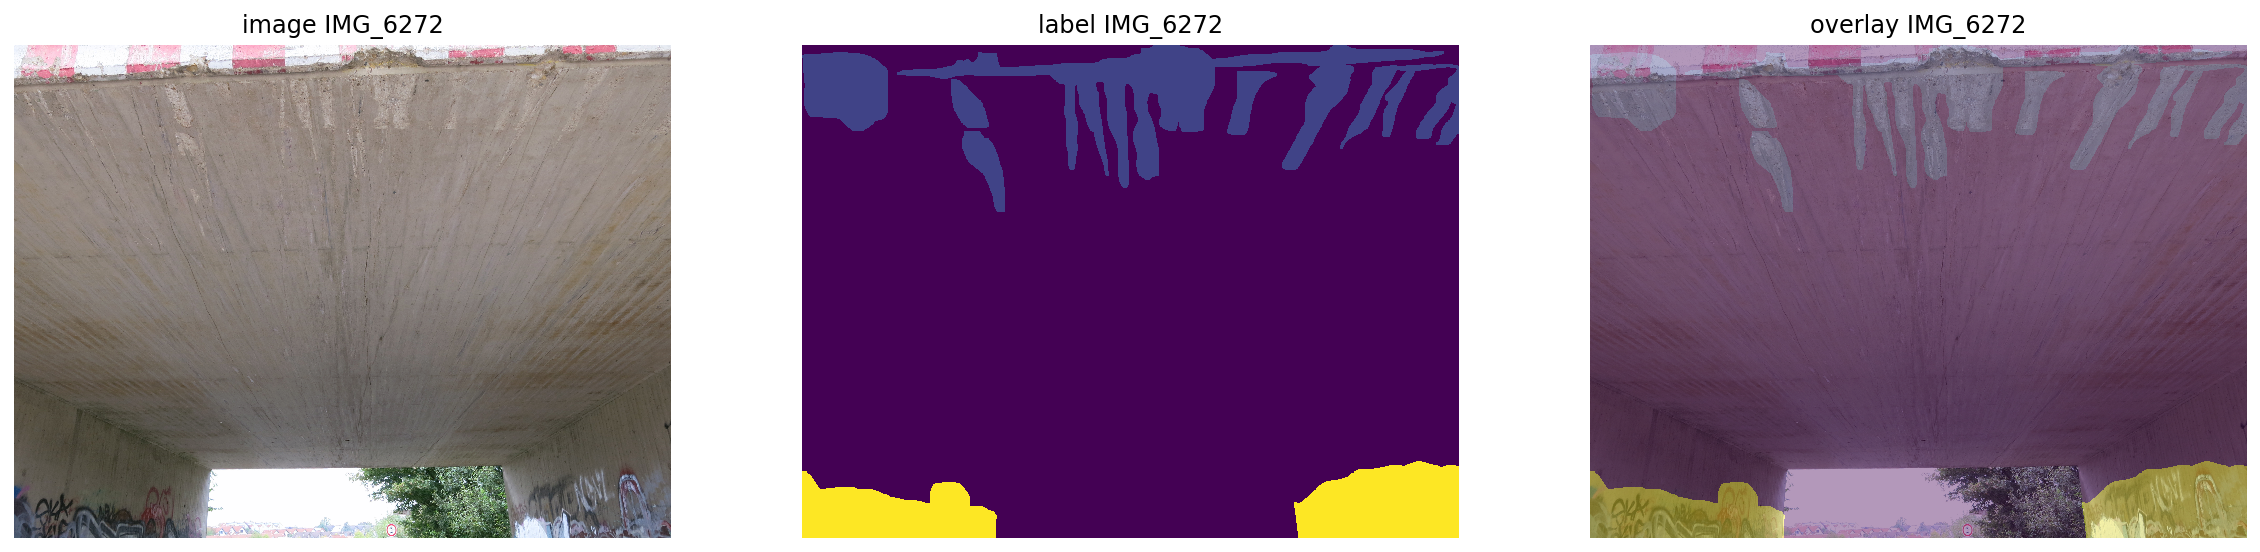

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (20,10) 
from libs.visualization import show_pair
show_pair(image_id, image, gt_label, (CONFIG.IMAGE.MEAN.B, CONFIG.IMAGE.MEAN.G, CONFIG.IMAGE.MEAN.R))

In [8]:
# Model
model = eval(CONFIG.MODEL.NAME)(n_classes=CONFIG.DATASET.N_CLASSES)
state_dict = torch.load(model_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state_dict)
model = nn.DataParallel(model)
model.eval()
model.to(device)
print("done")

done


In [9]:
image = image.to(device)
logit = model(image)
_, H, W = gt_label.shape
logit = F.interpolate(
    logit, size=(H, W), mode="bilinear", align_corners=False
)
prob = F.softmax(logit, dim=1)
label = torch.argmax(prob, dim=1)

In [10]:
from libs.visualization import preprocess_triplet
image, gt_label, label, image_id = preprocess_triplet(
    image.cpu(), gt_label.cpu(), label.cpu(), image_id, (CONFIG.IMAGE.MEAN.B, CONFIG.IMAGE.MEAN.G, CONFIG.IMAGE.MEAN.R)
)

In [11]:
"""%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (20,10) 
from libs.visualization import show_triplet
show_triplet(image_id, image, gt_label, label, image_id)"""

'%matplotlib inline\n%config InlineBackend.figure_format = \'retina\'\nplt.rcParams["figure.figsize"] = (20,10) \nfrom libs.visualization import show_triplet\nshow_triplet(image_id, image, gt_label, label, image_id)'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


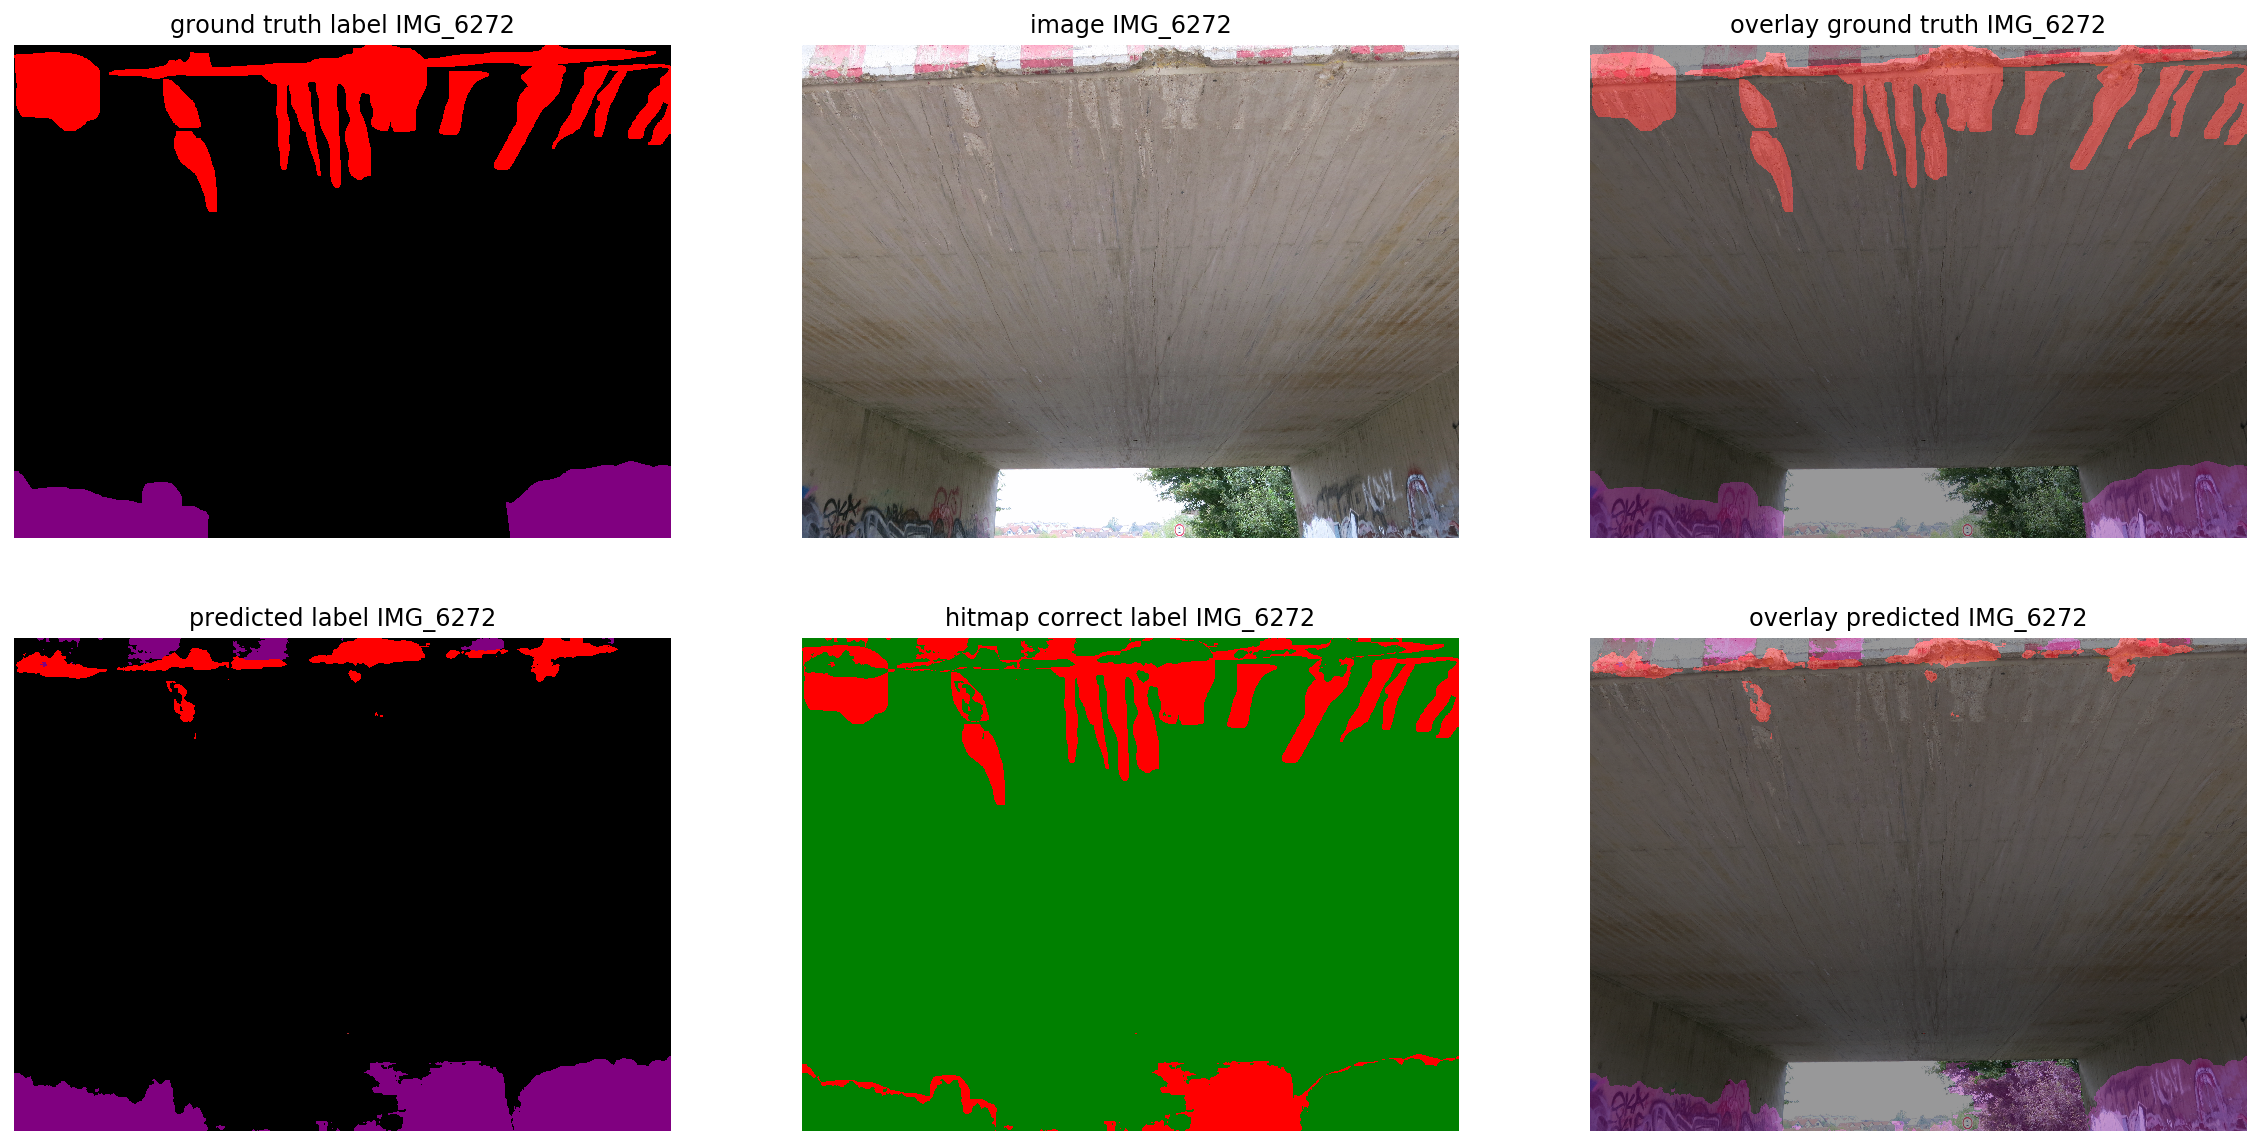

In [12]:
peformanceVis_path= "S2DSdevkit/merged/performanceVis/"

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (20,10) 
from libs.visualization import save_triplet
save_triplet(image_id, image, gt_label, label, peformanceVis_path)

In [16]:
for image_ids, images, gt_labels in tqdm(
        loader, total=len(loader), dynamic_ncols=True
    ):
    images = images.to(device)
    logits = model(images)
    _, H, W = gt_labels.shape
    logits = F.interpolate(
        logits, size=(H, W), mode="bilinear", align_corners=False
    )
    probs = F.softmax(logits, dim=1)
    labels = torch.argmax(probs, dim=1)
    images, gt_labels, labels, image_ids = preprocess_triplet(
        images.cpu(), gt_labels.cpu(), labels.cpu(), image_ids, (CONFIG.IMAGE.MEAN.B, CONFIG.IMAGE.MEAN.G, CONFIG.IMAGE.MEAN.R)
    )
    save_triplet(image_ids, images, gt_labels, labels, peformanceVis_path)

  0%|          | 0/157 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  1%|          | 1/157 [00:07<20:46,  7.99s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  2%|▏         | 3/157 [00:08<10:37,  4.14s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] fo

 16%|█▌        | 25/157 [01:39<08:49,  4.01s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 17%|█▋        | 26/157 [01:40<06:29,  2.97s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 17%|█▋        | 27/157 [01:43<06:21,  2.93s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 31%|███       | 49/157 [03:16<05:44,  3.19s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 32%|███▏      | 50/157 [03:19<05:51,  3.28s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 32%|███▏      | 51/157 [03:20<04:16,  2.42s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 54%|█████▎    | 84/157 [05:10<01:36,  1.32s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 55%|█████▌    | 87/157 [05:19<02:10,  1.87s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 56%|█████▌    | 88/157 

 70%|███████   | 110/157 [07:06<04:33,  5.83s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 71%|███████   | 111/157 [07:07<03:13,  4.21s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 71%|███████▏  | 112/157 [07:15<04:01,  5.37s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 90%|█████████ | 142/157 [08:52<00:59,  3.96s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 91%|█████████ | 143/157 [08:57<01:01,  4.39s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 92%|█████████▏| 145/157 [09:05<00:47,  3.94s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fb88314f7b8> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fb8831562f0> (for post_execute):


KeyboardInterrupt: 